# SCNN


## Imports
All the imports are defined here

In [37]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Helper functions
Set of helper functions

In [60]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
    plt.show()    
    
def show_plot(iternation, loss):
    plt.plot(iternation, loss)
    plt.xlabel('iternation')
    plt.ylabel('Loss')
    plt.title('Loss per iternation')
    plt.show()


## Configuration Class
A simple class to manage configuration

In [55]:
class Config():
    training_dir = "./siamese-datasets/datasets/train"
    testing_dir = "./siamese-datasets/datasets/test"
    train_batch_size = 2
    train_number_epochs = 250

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [40]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)



## Using Image Folder Dataset

In [41]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [42]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

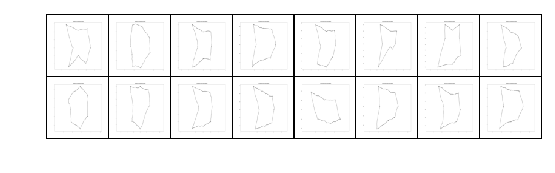

[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]]


In [43]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Neural Net Definition
We will use a standard convolutional neural network

In [8]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 100),
            nn.ReLU(inplace=True),

            nn.Linear(100, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [44]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Time!

In [45]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [51]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 2e-3)

1st  Trainning

In [ ]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)


In [64]:
class Config():
    training_dir = "./siamese-datasets/datasets/train"
    testing_dir = "./siamese-datasets/datasets/test"
    train_batch_size = 2
    train_number_epochs = 150

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import numpy as np

def calculate_accuracy(output1, output2, labels):
    # Concatenate output1 and output2
    concatenated_outputs = torch.cat((output1, output2), dim=0)
    
    # Concatenate labels (assuming 0 for negative class and 1 for positive class)
    concatenated_labels = torch.cat((labels, labels), dim=0)
    
    # Move tensors to CPU if they are on GPU
    concatenated_outputs = concatenated_outputs.cpu()
    concatenated_labels = concatenated_labels.cpu()
    
    # Apply softmax to obtain probabilities
    probabilities = torch.softmax(concatenated_outputs, dim=1)
    
    # Convert tensors to numpy arrays
    probabilities = probabilities.detach().numpy()
    concatenated_labels = concatenated_labels.detach().numpy()
    
    # Calculate AUC-ROC score
    auc_roc_score = roc_auc_score(concatenated_labels, probabilities, multi_class='ovr')
    
    # Convert AUC-ROC score to accuracy
    accuracy = (auc_roc_score * 2) - 1
    
    return accuracy.item()
# Biến để lưu trữ số lượng epoch, loss và accuracy
epoch_counter = []
loss_history = []
accuracy_history = []

# Vòng lặp huấn luyện
for epoch in range(Config.train_number_epochs):
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    for i, data in enumerate(train_dataloader, 0):
        img0, img1, label = data
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()
        

        accuracy = calculate_accuracy(output1, output2, label)
        
        epoch_loss += loss_contrastive.item()
        epoch_accuracy += accuracy
        
        if i % 10 == 0:
            print("Epoch number {}\n Current loss {}\n Current accuracy {}\n".format(
                epoch, loss_contrastive.item(), accuracy))
    
   
    epoch_loss /= len(train_dataloader)
    epoch_accuracy /= len(train_dataloader)
    
    loss_history.append(epoch_loss)
    accuracy_history.append(epoch_accuracy)
    epoch_counter.append(epoch)

def show_plot(epoch_counter, loss_history, accuracy_history):
    plt.figure(figsize=(10,))
    
    plt.subplot(1, 2, 1)
    plt.plot(epoch_counter, loss_history, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epoch_counter, accuracy_history, label='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()
    
    plt.show()

# Gọi hàm show_plot để vẽ biểu đồ
show_plot(epoch_counter, loss_history, accuracy_history)


In [66]:
def mapping(value, old_min=0, old_max=2.8, new_min=0, new_max=1):
    # Ensure the value is within the old range
    if not (old_min <= value <= old_max):
        raise ValueError(f"Input value should be in the range [{old_min}, {old_max}].")
    
    # Perform the mapping
    old_range = old_max - old_min
    new_range = new_max - new_min
    scaled_value = ((value - old_min) * new_range / old_range) + new_min
    
    return scaled_value

## Testing

In [67]:
import os
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("on")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':2})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    name = os.path.join("results",str(i)+".png")
    plt.savefig(name, bbox_inches='tight', pad_inches=0)
    plt.show() 

In [ ]:
import os
folder_dataset_test = dset.ImageFolder(root=Config.training_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)


for i in range(8):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    euclidean_distance = euclidean_distance.item()
    # euclidean_distance = mapping(euclidean_distance)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance), i)
    # np_image = concatenated.numpy().transpose((1, 2, 0))
    # plt.imshow(np_image)
    # plt.axis('off') 
    # name = os.path.join("results",str(i)+".png")
    # plt.savefig(name, bbox_inches='tight', pad_inches=0)
    